# 6. SHapley Additive exPlanations (SHAP)


### ALE description:
- Kernel SHAP: https://docs.seldon.io/projects/alibi/en/stable/methods/KernelSHAP.html
- Tree SHAP: https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html

### API Reference:
- Kernel SHAP: https://docs.seldon.io/projects/alibi/en/stable/api/alibi.explainers.shap_wrappers.html
- Tree SHAP: https://docs.seldon.io/projects/alibi/en/stable/api/alibi.explainers.shap_wrappers.html

### Related paper:
- Kernel SHAP: [Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Proceedings of the 31st international conference on neural information processing systems. 2017.](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)
- Tree SHAP: [Lundberg, Scott M., et al. "From local explanations to global understanding with explainable AI for trees." Nature machine intelligence 2.1 (2020): 56-67.](https://www.nature.com/articles/s42256-019-0138-9.pdf)

---

## 6-1. Kernel SHAP 
The Kernel SHAP algorithm provides model-agnostic (black box), human interpretable explanations suitable for regression and classification models applied to tabular data. This method is a member of the additive feature attribution methods class; feature attribution refers to the fact that the change of an outcome to be explained (e.g., a class probability in a classification problem) with respect to a baseline (e.g., average prediction probability for that class in the training set) can be attributed in different proportions to the model input features.

## Kernel SHAP explanation for SVM models
In this example, we show how to explain a multi-class classification model based on the SVM algorithm using the KernelSHAP method. We show how to perform instance-level (or local) explanations on this model as well as how to draw insights about the model behaviour in general by aggregating information from explanations across many instances (that is, perform global explanations).

In [55]:
import shap
shap.initjs()

import matplotlib.pyplot as plt
import numpy as np

from alibi.explainers import KernelShap
from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### Data preparation

In [56]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [57]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [59]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

### Training

SVM, is a binary classifier, so multiple classifiers are fitted in order to support multiclass classification.

In [60]:
np.random.seed(0)
classifier = SVC(
    kernel = 'rbf',
    C=1,
    gamma = 0.1,
    decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
    random_state = 0,
)
classifier.fit(X_train_norm, y_train)

SVC(C=1, gamma=0.1, random_state=0)

### Model assessment
Look at confusion matrix.

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Confusion matrix for SVC classifier')

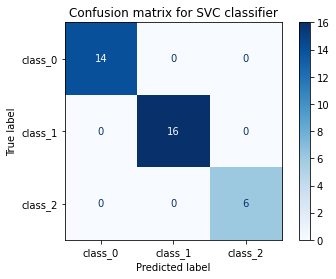

In [61]:
y_pred = classifier.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)

title = 'Confusion matrix for SVC classifier'
disp = plot_confusion_matrix(classifier,
                             X_test_norm,
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

The confusion matrix show the classifier is perfect 

### Apply KernelSHAP to explain the model

In [63]:
pred_fcn = classifier.decision_function

In [64]:
np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            ,
  'version': '0.6.2'}
)

In [65]:
# expected_values attribute stores average scores across training set for every binary SVM
mean_scores_train = pred_fcn(X_train_norm).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)

[-1.11022302e-16  4.44089210e-16 -4.44089210e-16]


In [66]:
svm_explanation = svm_explainer.explain(X_test_norm, l1_reg=False)

  0%|          | 0/36 [00:00<?, ?it/s]

### Local explanation

Because the SVM algorithm returns a score for each of the 3 classes, the shap_values are computed for each class in turn. Moreover, the attributions are computed for each data point to be explained and for each feature, resulting in a $N_e \times D$ matrix of shap values for each classs, where $N_e$ is the number of instances to be explained and D is the number of features.

In [67]:
print("Output type:", type(svm_explanation.shap_values))
print("Output size:", len(svm_explanation.shap_values))
print("Class output size:", svm_explanation.shap_values[0].shape)

Output type: <class 'list'>
Output size: 3
Class output size: (36, 13)


For a given instance, we can visualise the attributions using a force plot. Let’s choose the first example in the testing set as an example.

In [68]:
idx =  0
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
class_idx = pred.item()
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test_norm[0] is 0.
OVR decision function values are [ 2.24071294  0.85398239 -0.21510456].


We see that class 0 is predicted because the SVM model trained with class 0 as a positive class and classes 1 and 2 combined as a negative class returned the largest score.

To create this force plot, we have provided the plotting function with four inputs: - the expected predicted score by the class-0 SVM assuming all inputs are missing. This is marked as the base value on the force plot - the feature attributions for the instance to be explained - the instance to be explained - the feature names

In [70]:
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx][idx, :] ,
    instance,
    feature_names,
)

The force plot depicts the contribution of each feature to the process of moving the value of the decision score from the base value (estimation of the decision score if all inputs were missing) to the value predicted by the classifier. We see that all features contribute to increasing the decision score, and that the largest increases are due to the proline feature with a value of 1.049 and the flavanoids feature with a value of 0.9778. The lengths of the bars are the corresponding feature attributions.

Similarly, below we see that the proline and alcohol features contribute the to decreasing the decision score of the SVM predicting class 1 as positive and that the malic_acid feature increases the decision score.

In [71]:
shap.force_plot(
    svm_explainer.expected_value[1],
    svm_explanation.shap_values[1][idx, :] ,
    instance,
    feature_names,
)

An alternative way to visualise local explanations for multi-output models is a multioutput decision plot. This plot can be especially useful when the number of features is large and the force plot might not be readable.

In [72]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)

    if not class_names:
        class_names = [f'Class {i}' for i in range(decision_scores.shape[1])]

    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))

    return class_names

In [73]:
legend_labels = class_labels(classifier, instance)

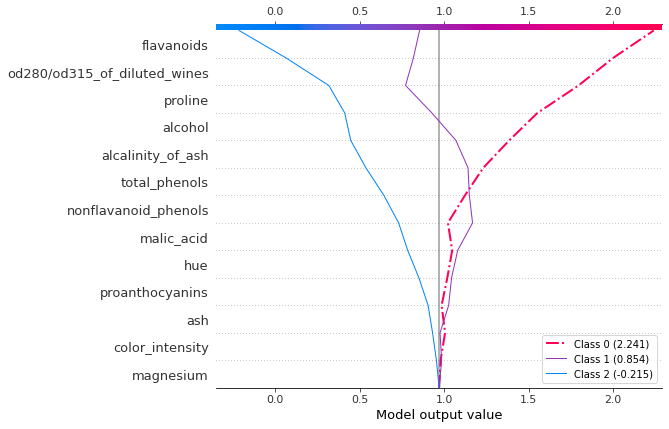

In [74]:
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(),
                                   svm_explanation.shap_values,
                                   idx,
                                   feature_names=feature_names,
                                   feature_order='importance',
                                   highlight=[class_idx],
                                   legend_labels=legend_labels,
                                   return_objects=True,
                                   legend_location='lower right')

The decision plots shows how the individual features influence contribute to the classification into each of the three classes (a prediction path). One sees that, for this example, the model can easily separate the three classes. It also shows, for example, that a wine with the given alcohol content is typical of class 0 (because the alcohol feature contributes positively to a classification of class 0 as negatively to classification in classes 1 and 2)

Note that the feature ordering is determined by summing the shap value magnitudes corresponding to each feature across classes and then ordering the feature_names in descending order of cumulative magniture. The plot origin, marked by the gray vertical line, is the average base values across the classes. The dashed line represents the model prediction - in general we can highlight a particular class by passing the class index in the highlight list.

Suppose now that we want to analyse instance 5 but realise that the feature importances are different for this instance.

In [76]:
idx =  5
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
                          
instance_shap = np.array(svm_explanation.shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::-1]
feat_importance = [feature_names[i] for i in feature_order]
                          
print(feat_importance)

['flavanoids', 'alcalinity_of_ash', 'od280/od315_of_diluted_wines', 'alcohol', 'ash', 'total_phenols', 'proline', 'proanthocyanins', 'magnesium', 'hue', 'malic_acid', 'nonflavanoid_phenols', 'color_intensity']


We want to create a multi-output decision plot with the same feature order and scale. This is possible, since by passing the return_objects=True to the plotting function in the example above, we retrieved the feature indices and the axis limits and can reuse them to display the decision plot for instance 5 with the same feature order as above.

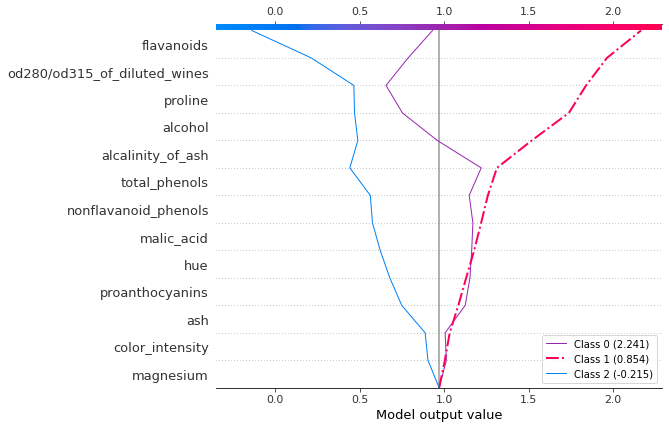

In [77]:
shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(),
                               svm_explanation.shap_values,
                               idx,
                               feature_names=feature_names,
                               feature_order=r.feature_idx,
                               highlight=[pred.item()],
                               legend_labels=legend_labels,
                               legend_location='lower right',
                               xlim=r.xlim,
                               return_objects=False)

### Global explanation

As shown above, the force plot allows us to understand how the individual features contribute to a classification output given an instance. However, the particular explanation does not tell us about the model behaviour in general. Below, we show how such insights can be drawn.

#### Stacked force plots

The simplest way we can do this is to stack the force plot for a number of instances, which can be achieved by calling the force_plot function with the same arguments as before but replacing instance with the whole testing set, X_test_norm.

In [78]:
class_idx = 0 # we explain the predicted label
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx],
    X_test_norm,
    feature_names,
)

In the default configuration, the x axis is represented by the 36 instances in X_test_norm whereas the y axis represents the decision score. Note that, like before, the decision score is for class 0. For a given instance, the height in between two horizontal lines is equal to the shap value of the feature, and hovering over a plot shows a list of the features along with their values, sorted by shap values. As before, the blue shading shows a negative contribution to the decision score (moves the score away from the baseline value) whereas the pink shading shows a positive contribution to the decision score. Hovering over the plot, tells us, for example, that to achieve a high decision score (equivalent to class 0 membership) the features proline and flavanoids are generally the most important and that positive proline values lead to higher decision scores for belonging to this class whereas negative proline values provide evidence against this one belonging to 0 class.

To see the relationship between decision scores and the values more clearly, we can permute the x axis so that the instances are sorted according to the value of the proline feature by selecting proline from the horizontal drop down menu.

In [79]:
shap.force_plot(
    svm_explainer.expected_value[class_idx],
    svm_explanation.shap_values[class_idx],
    X_test_norm,
    feature_names,
)

You can also explore the effect of a particular feature across the testing dataset. For example, in the plot below, by selecting flavanoids from the top drop-down, the instances are ordered on the x axis in increasing value of the flavanoids feature.

Similarly, selecting flavanoids effects from the side drop-down will plot the shap value as opposed to the model output. The effect of this feature generally increases as its value increases and the large negative values of this feature reduce the decision score for classification as 0. Note that the shap values are respresented with resepect to the base value for this class (0.798, as shown below).

In [80]:
shap.force_plot(
    svm_explainer.expected_value[0],
    svm_explanation.shap_values[0],
    X_test_norm,
    feature_names,
)

In [81]:
print(svm_explainer.expected_value)

[0.79821894 1.41710253 0.69461514]


#### Summary plots

To visualise the impact of the features on the decision scores associated with class 0, we can use a summary plot. In this plot, the features are sorted by the sum of their SHAP values magnitudes across all instances in X_test_norm. Therefore, the features with the highest impact on the decision score for class class_idx are displayed at the top of the plot.

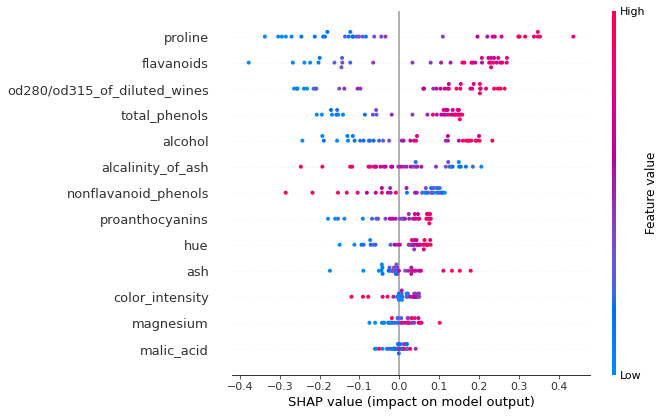

In [83]:
shap.summary_plot(svm_explanation.shap_values[0], X_test_norm, feature_names)

In this case, the proline and flavanoids have the most impact on the model output; as the values of the features increase, their impact also increases and the model is more likely to predict class 0. On the other hand, high values of the nonflavonoid_phenols have a negative impact on the model output, potentially contributing to the classification of the particular wine in a different class. To see this, we do a summary plot with respect to class_2.

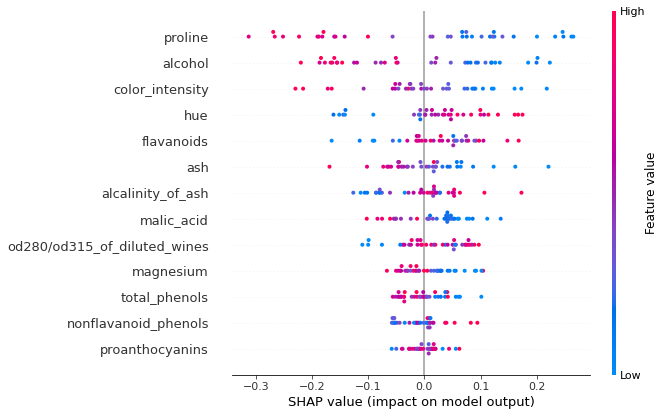

In [84]:
shap.summary_plot(svm_explanation.shap_values[1], X_test_norm, feature_names)

We see that, indeed, a higher value of the nonflavonoid_phenols feature contributes to a sample being classified as class 1, but that this effect is rather limited compared to features such as proline or alcohol.

To visualise the impact of the feature across all classes, that is, the importance of a particular feature for the model, we simply pass all the shap values to the summary_plot functions. We see, that, for example, the color_intensity feature is much more important for deciding whether an instance should be classified as class_2 then in class_0.

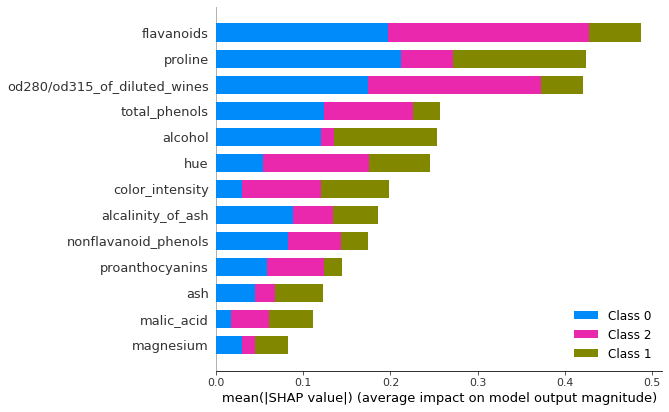

In [85]:
shap.summary_plot(svm_explanation.shap_values, X_test_norm, feature_names)

#### Dependence plots
Another way to visualise the model dependence on a particular feature is through a dependence plot. This plot shows the impact of the feature value on its importance for classification with respect to class 0.

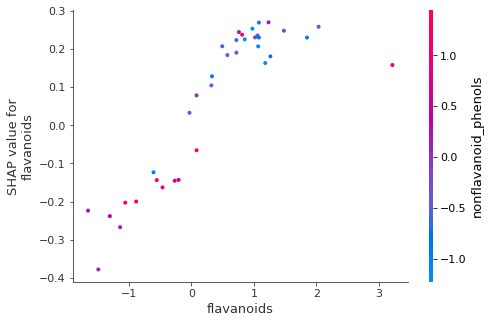

In [86]:
feature = 'flavanoids'
shap.dependence_plot(
    feature,
    svm_explanation.shap_values[0],
    X_test_norm,
    feature_names=feature_names,
    interaction_index='auto',
)

The colour of the individual instances is represented by the value of the feature nonflavanoid_phenols. By specifying interaction_index=auto, the nonflavanoid_phenols was estimated as a the feature with the strongest interaction with the flavanoids_feature; this interaction is approximate, and is estimate by computing the Pearson Correlation Coefficient between the shap values of the reference feature (flavanoids in this case) and the value of each feature in turn on bins along the feature value.

We see that, for class 0 wines, a higher value for nonfavanoid_phenols is generally associated with a low value in flavanoids and that they have a negative impact on the score for class 0 classification.

## 6-2. Tree SHAP 

The Tree SHAP algorithm provides human interpretable explanations suitable for regression and classification of models with tree structure applied to tabular data. This method is a member of the additive feature attribution methods class; feature attribution refers to the fact that the change of an outcome to be explained (e.g., a class probability in a classification problem) with respect to a baseline (e.g., average prediction probability for that class in the training set) can be attributed in different proportions to the model input features.

## Path-dependent Feature Perturbation Tree SHAP

This example shows how to apply path-dependent feature perturbation Tree SHAP to compute shap values exactly for an xgboost model fitted to the Adult dataset (binary classification task). An example of how to decompose the contribution of any given feature into a main effect and interactions with other features is also presented.

In [87]:
import pickle
import shap
shap.initjs()

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from alibi.datasets import fetch_adult
from alibi.explainers import TreeShap
from functools import partial
from itertools import product, zip_longest
from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix

from timeit import default_timer as timer

### Data preparation
#### Load and split
The fetch_adult function returns a Bunch object containing the features, targets, feature names and a mapping of categorical variables to numbers.

In [88]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [89]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use the utility function gen_category_map imported from alibi.utils.data to create the category map.

In [90]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [91]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

`xgboost` wraps arrays using DMatrix objects, optimised for both memory efficiency and training speed.

In [92]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train),
    label=wrap(y_train),
    feature_names=feature_names,
)

dtest = xgb.DMatrix(wrap(X_test), label=wrap(y_test), feature_names=feature_names)

Finally, a matrix that contains the raw string values for categorical variables (used for display) is created:

In [93]:
def _decode_data(X, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the
    categorical levels have been replaced by human readable categories.
    """

    X_new = np.zeros(X.shape, dtype=object)
    for idx, name in enumerate(feature_names):
        categories = category_map.get(idx, None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, idx] == j
                X_new[encoded_vals, idx] = category
        else:
            X_new[:, idx] = X[:, idx]

    return X_new

decode_data = partial(_decode_data, feature_names=feature_names, category_map=category_map)

In [94]:
X_display = decode_data(X_test)
X_display

array([[52, 'Private', 'Associates', ..., 0, 60, 'United-States'],
       [21, 'Private', 'High School grad', ..., 0, 20, 'United-States'],
       [43, 'Private', 'Dropout', ..., 0, 50, 'United-States'],
       ...,
       [23, 'Private', 'High School grad', ..., 0, 40, 'United-States'],
       [45, 'Local-gov', 'Doctorate', ..., 0, 45, 'United-States'],
       [25, 'Private', 'High School grad', ..., 0, 48, 'United-States']],
      dtype=object)

### Model definition

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from alibi.datasets import fetch_adult
from copy import deepcopy
from functools import partial
from itertools import chain, product
from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [103]:
learning_params = {}
booster_params = {}
general_params = {}
params = {}

In [104]:
def tune_params(dtrain, base_params,  param_dict, maximise=True, prev_optimum=None, **kwargs):
    """
        Given a training set `dtrain`, a dictionary of parameters to be optimised `param_dict` and
        all the other learning and booster parameters (`base_param`), this function runs an
        exhaustive grid search over the tuning parameters.

        NB: Specifying `prev_optimum` allows one to tune parameters in stages. maximise should indicate
        if the evaluation metric should be maximised during CV.
    """

    def _statistic(maximise, argument=False):
        if maximise:
            if argument:
                return np.argmax
            return np.max
        if argument:
            return np.argmin
        return np.min


    def _compare(optimum, val, maximise=True):

        eps=1e-4

        if maximise:
            if val > optimum + eps:
                return True
            return False
        if val < optimum - eps:
            return True
        return False

    statistic = partial(_statistic, maximise)
    compare = partial(_compare, maximise=maximise)
    metrics = kwargs.get("metrics")
    if isinstance(metrics, list):
        opt_metric = metrics[-1]
    else:
        opt_metric = metrics

    print(f"CV with params: {list(param_dict.keys())}")
    print(f"Tracked metrics: {metrics}")
    print(f"Cross-validating on: {opt_metric}")

    if prev_optimum:
        optimum = prev_optimum
    else:
        optimum = -float("Inf") if maximise else float("Inf")

    params = deepcopy(base_params)
    pars, pars_val = list(param_dict.keys()), list(param_dict.values())
    combinations = list(product(*pars_val))
    best_combination = {}

    # run grid search
    for combination in tqdm(combinations):
        for p_name, p_val in zip(pars, combination):
            params[p_name] = p_val
        cv_results = xgb.cv(
            params,
            dtrain,
            **kwargs,
        )
        mean = statistic()(cv_results[f'test-{opt_metric}-mean'])
        boost_rounds = statistic(argument=True)(cv_results[f'test-{opt_metric}-mean'])
        improved = compare(optimum, mean)
        if improved:
            optimum = mean
            for name, val in zip(pars, combination):
                best_combination[name]=val
            print(f"{opt_metric} mean value: {mean} at {boost_rounds} rounds")
            msg = 'Best params:' + '\n{}: {}'*len(pars)
            print(msg.format(*list(chain(*best_combination.items()))))

    return optimum, best_combination, boost_rounds

In [105]:
booster_params.update({'eta': 0.1})

tuning_params={
        'scale_pos_weight': [2, 3, 4, 5],
        'min_child_weight': [0.1, 0.5, 1.0, 2.0, 5.0],
        'max_depth': [3, 4, 5],
        'gamma': [0.01, 0.05, 0.08, 0.1, 0.2]
}

In [106]:
params.update(general_params)
params.update(learning_params)
params.update(booster_params)

cv_opts = {
    'num_boost_round': 1000,
    'nfold': 5,
    'stratified': True,
    'metrics': ['logloss', 'aucpr', 'auc'],  # can alternatively perform early stopping on log-loss or aucpr
    'early_stopping_rounds': 20,
    'seed': 42,
}

In [107]:
optimum, best_params, boost_rounds = tune_params(dtrain,
                                                 params,
                                                 tuning_params,
                                                 maximise=True,
                                                 **cv_opts
                                                )

if best_params:
    params.update(best_params)
    params.update({'boost_rounds': boost_rounds})
params

CV with params: ['scale_pos_weight', 'min_child_weight', 'max_depth', 'gamma']
Tracked metrics: ['logloss', 'aucpr', 'auc']
Cross-validating on: auc


  0%|▌                                                                                                                                                                         | 1/300 [00:46<3:52:34, 46.67s/it]

auc mean value: 0.9259154 at 711 rounds
Best params:
scale_pos_weight: 2
min_child_weight: 0.1
max_depth: 3
gamma: 0.01


  2%|███▉                                                                                                                                                                      | 7/300 [03:41<2:15:42, 27.79s/it]

auc mean value: 0.9260466 at 320 rounds
Best params:
scale_pos_weight: 2
min_child_weight: 0.1
max_depth: 4
gamma: 0.05


 17%|████████████████████████████▋                                                                                                                                            | 51/300 [21:58<1:58:22, 28.52s/it]

auc mean value: 0.9262368000000001 at 330 rounds
Best params:
scale_pos_weight: 2
min_child_weight: 2.0
max_depth: 4
gamma: 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:59:13<00:00, 23.85s/it]


{'eta': 0.1,
 'scale_pos_weight': 2,
 'min_child_weight': 2.0,
 'max_depth': 4,
 'gamma': 0.01,
 'boost_rounds': 164}

In [108]:
learning_params = {
    'objective':'binary:logitraw',
    'seed': 42,
    'eval_metric': ['auc', 'logloss'] # metrics computed for specified dataset
}


params = {
    'scale_pos_weight': 2,
    'min_child_weight': 0.1,
    'max_depth': 3,
    'gamma': 0.01,
    'boost_rounds': 541,
}

params.update(learning_params)


In [109]:
if 'boost_rounds' in params:
    boost_rounds = params.pop('boost_rounds')

model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds,
    evals=[(dtrain, "Train"), (dtest, "Test")],
)
model.save_model('adult_xgb.mdl')

[0]	Train-auc:0.85583	Train-logloss:3.24583	Test-auc:0.86238	Test-logloss:3.10636
[1]	Train-auc:0.86776	Train-logloss:2.75590	Test-auc:0.86981	Test-logloss:2.75162
[2]	Train-auc:0.87293	Train-logloss:2.73399	Test-auc:0.87645	Test-logloss:2.72548
[3]	Train-auc:0.88608	Train-logloss:2.65853	Test-auc:0.88777	Test-logloss:2.68383
[4]	Train-auc:0.89097	Train-logloss:2.72010	Test-auc:0.89187	Test-logloss:2.73920
[5]	Train-auc:0.89587	Train-logloss:2.26391	Test-auc:0.89655	Test-logloss:2.26780
[6]	Train-auc:0.89975	Train-logloss:3.02352	Test-auc:0.90116	Test-logloss:3.03143
[7]	Train-auc:0.90348	Train-logloss:2.81292	Test-auc:0.90578	Test-logloss:2.78612
[8]	Train-auc:0.90417	Train-logloss:2.82292	Test-auc:0.90628	Test-logloss:2.77500
[9]	Train-auc:0.90722	Train-logloss:3.28116	Test-auc:0.91048	Test-logloss:3.33281
[10]	Train-auc:0.90799	Train-logloss:3.29612	Test-auc:0.91155	Test-logloss:3.32141
[11]	Train-auc:0.90900	Train-logloss:3.36206	Test-auc:0.91211	Test-logloss:3.33176
[12]	Train-auc

In [110]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """

    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()

def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits.
    """

    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred)
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label

    return y_pred_class

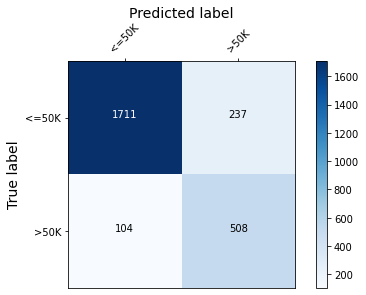

In [111]:
model = xgb.Booster()
model.load_model('adult_xgb.mdl')

y_pred_train = predict(model, dtrain)
y_pred_test = predict(model, dtest)

plot_conf_matrix(y_test, y_pred_test, target_names)

In [112]:
print(f'Train accuracy:  {round(100*accuracy_score(y_train, y_pred_train), 4)}  %.')
print(f'Test  accuracy:  {round(100*accuracy_score(y_test, y_pred_test), 4)}%.')

Train accuracy:  87.75  %.
Test  accuracy:  86.6797%.


### Explaining xgboost via global feature importance

In [113]:
def _get_importance(model, measure='weight'):
    """
    Retrieves the feature importances from an xgboost
    models, measured according to the criterion `measure`.
    """

    imps = model.get_score(importance_type=measure)
    names, vals = list(imps.keys()), list(imps.values())
    sorter = np.argsort(vals)
    s_names, s_vals = tuple(zip(*[(names[i], vals[i]) for i in sorter]))

    return s_vals[::-1], s_names[::-1]

def plot_importance(feat_imp, feat_names, ax=None, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """

    left_x, step ,right_x = kwargs.get("left_x", 0), kwargs.get("step", 50), kwargs.get("right_x")
    xticks = np.arange(left_x, right_x, step)
    xlabel = kwargs.get("xlabel", 'Feature effects')
    xposfactor = kwargs.get("xposfactor", 1)
    textfont = kwargs.get("text_fontsize", 25) # 16
    yticks_fontsize = kwargs.get("yticks_fontsize", 25)
    xlabel_fontsize = kwargs.get("xlabel_fontsize", 30)
    textxpos = kwargs.get("textxpos", 60)
    textcolor = kwargs.get("textcolor", 'white')

    if ax:
        fig = None
    else:
        fig, ax = plt.subplots(figsize=(10, 5))

    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=yticks_fontsize)
    ax.set_xticklabels(xticks, fontsize=30, rotation=45)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    ax.set_xlim(left=left_x, right=right_x)

    for i, v in enumerate(feat_imp):
#         if v<0:
        textxpos = xposfactor*textxpos
        ax.text(v - textxpos, i + .25, str(round(v, 3)), fontsize=textfont, color=textcolor)
    return ax, fig

get_importance = partial(_get_importance, model)


FixedFormatter should only be used together with FixedLocator


(<AxesSubplot:xlabel='Feature effects (gain)'>, None)

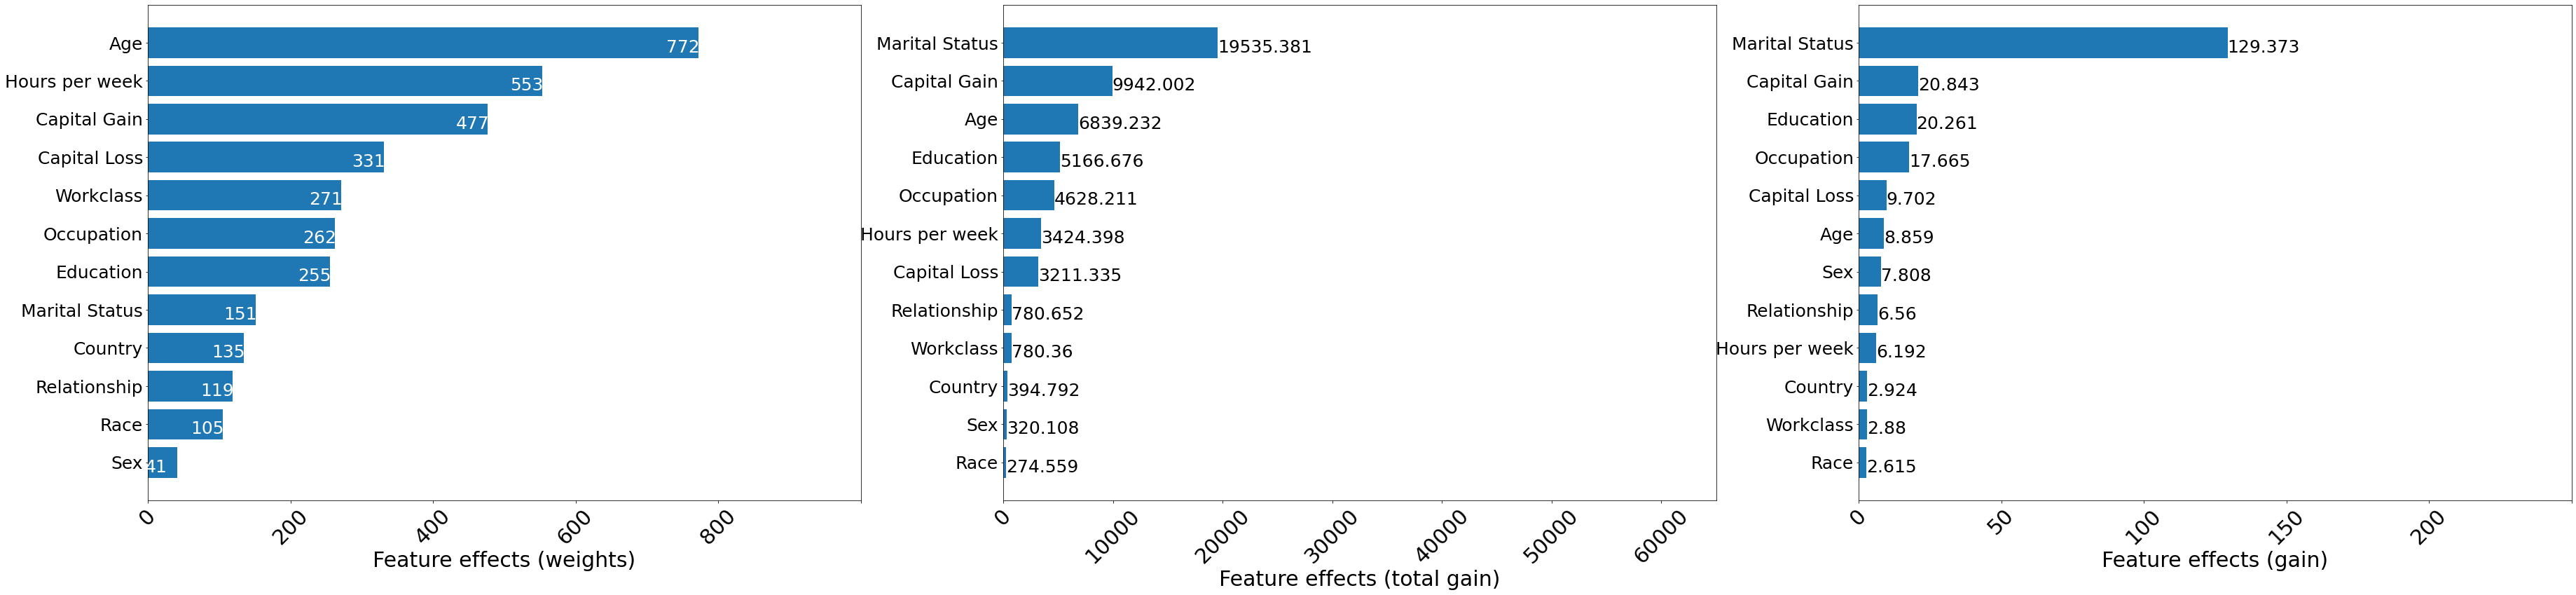

In [114]:
imp_by_weight_v, imp_by_weight_n = get_importance()
imp_by_gain_v, imp_by_gain_n = get_importance(measure='total_gain')
imp_by_a_gain_v, imp_by_a_gain_n = get_importance(measure='gain')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(62, 13))
plot_importance(imp_by_weight_v, imp_by_weight_n, ax=ax1, xlabel='Feature effects (weights)', textxpos=45, right_x=1000, step=200 )
plot_importance(imp_by_gain_v, imp_by_gain_n, ax=ax2, xlabel='Feature effects (total gain)', textxpos=5, right_x=65000, step=10000, textcolor='black')
plot_importance(imp_by_a_gain_v, imp_by_a_gain_n, ax=ax3, xlabel='Feature effects (gain)', textxpos=0, right_x=250, step=50, textcolor='black')

### Explaining xgboost with path-dependent Tree SHAP: global knowledge from local explanations

In [115]:
path_dependent_explainer = TreeShap(model, model_output='raw', task='classification')
path_dependent_explainer.fit() # does not require background_data

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


TreeShap(meta={
  'name': 'TreeShap',
  'type': ['whitebox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'model_output': 'raw',
              'summarise_background': False,
              'summarise_result': None,
              'approximate': None,
              'interactions': None,
              'explain_loss': None,
              'algorithm': 'tree_path_dependent',
              'kwargs': {}}
            ,
  'version': '0.6.2'}
)

In [116]:
path_dependent_explanation = path_dependent_explainer.explain(X_test)
path_dependent_shap_values = path_dependent_explanation.shap_values[0]

np.max(np.abs(model.predict(dtest) - path_dependent_explainer.expected_value - path_dependent_shap_values.sum(1)))

1.8119812e-05

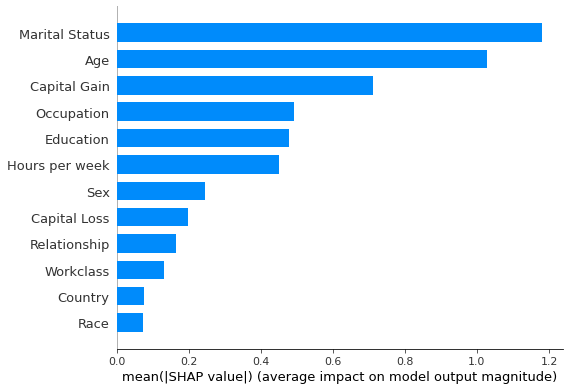

In [117]:
shap.summary_plot(path_dependent_shap_values, X_test, feature_names, plot_type='bar')

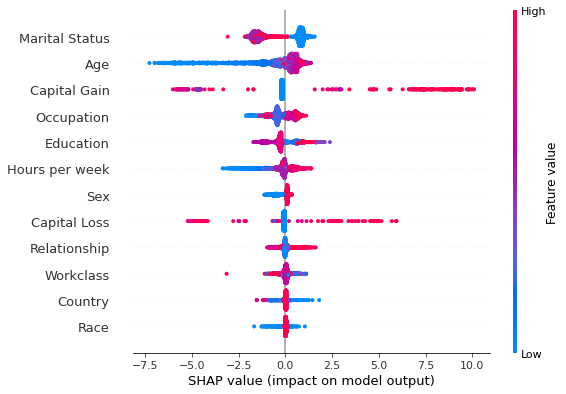

In [118]:
shap.summary_plot(path_dependent_shap_values, X_test, feature_names, class_names=target_names)

In [119]:
from collections import Counter

feat_name = 'Marital Status'
decode_dict = {}
for i, val in enumerate(category_map[feature_names.index(feat_name)]):
    decode_dict[i] = val
print("Mapping of feature encoded values to readable values", decode_dict)

Mapping of feature encoded values to readable values {0: 'Married', 1: 'Never-Married', 2: 'Separated', 3: 'Widowed'}


In [120]:
def _dependence_plot(features, shap_values, dataset, feature_names, category_map, display_features=None, **kwargs):
    """
    Plots dependence plots of specified features in a grid.

    features: List[str], List[Tuple[str, str]]
        Names of features to be plotted. If List[str], then shap
        values are plotted as a function of feature value, coloured
        by the value of the feature determined to have the strongest
        interaction (empirically). If List[Tuple[str, str]], shap
        interaction values are plotted.
    display_features: np.ndarray, N x F
        Same as dataset, but contains human readable values
        for categorical levels as opposed to numerical values
    """

    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].tick_params(labelrotation=cbartickrotation)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    figsize = kwargs.get("figsize", (15, 10))
    nrows = kwargs.get('nrows', len(features))
    ncols = kwargs.get('ncols', 1)
    xlabelfontsize = kwargs.get('xlabelfontsize', 14)
    xtickfontsize = kwargs.get('xtickfontsize', 11)
    ylabelfontsize = kwargs.get('ylabelfontsize', 14)
    ytickfontsize = kwargs.get('ytickfontsize', 11)
    cbartickfontsize = kwargs.get('cbartickfontsize', 14)
    cbartickrotation = kwargs.get('cbartickrotation', 10)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 14)
    rotation_orig = kwargs.get('xticklabelrotation', 25)

    alpha = kwargs.get("alpha", 1)
    x_jitter_orig = kwargs.get("x_jitter", 0.8)
    grouped_features = list(zip_longest(*[iter(features)] * ncols))


    fig, axes = plt.subplots(nrows, ncols,  figsize=figsize)
    if nrows == len(features):
        axes = list(zip_longest(*[iter(axes)] * 1))


    for i, (row, group) in enumerate(zip(axes, grouped_features), start=1):
        # plot each feature or interaction in a subplot
        for ax, feature in zip(row, group):
            # set x-axis ticks and labels and x-jitter for categorical variables
            if not feature:
                continue
            if isinstance(feature, list) or isinstance(feature, tuple):
                feature_index = feature_names.index(feature[0])
            else:
                feature_index = feature_names.index(feature)
            if feature_index in category_map:
                ax.set_xticks(np.arange(len(category_map[feature_index])))
                if i == nrows:
                    rotation = 90
                else:
                    rotation = rotation_orig
                ax.set_xticklabels(category_map[feature_index], rotation=rotation, fontsize=22)
                x_jitter = x_jitter_orig
            else:
                x_jitter = 0

            shap.dependence_plot(feature,
                                 shap_values,
                                 dataset,
                                 feature_names=feature_names,
                                 display_features=display_features,
                                 interaction_index='auto',
                                 ax=ax,
                                 show=False,
                                 x_jitter=x_jitter,
                                 alpha=alpha
                                )
            if i!= nrows:
                ax.tick_params('x', labelrotation=rotation_orig)
            _set_fonts(fig, ax, set_cbar=True)

plot_dependence = partial(
    _dependence_plot,
    feature_names=feature_names,
    category_map=category_map,
)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


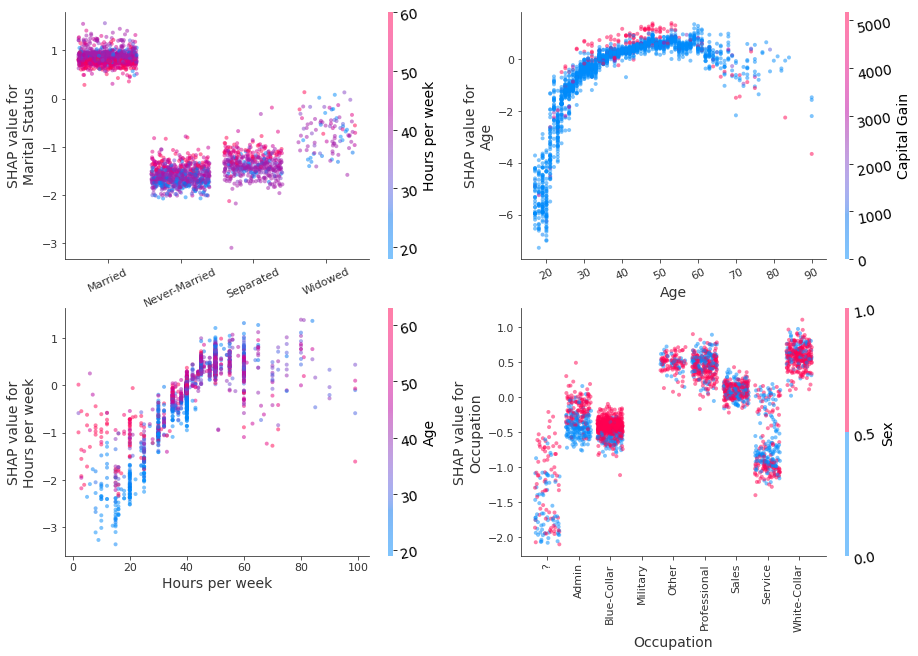

In [121]:
plot_dependence(
    ['Marital Status', 'Age', 'Hours per week', 'Occupation'],
    path_dependent_shap_values,
    X_test,
    alpha=0.5,
    x_jitter=0.8,
    nrows=2,
    ncols=2,
)

In [122]:
# identify false negatives
misclassified = (np.logical_and(y_test == 1, y_pred_test == 0)).nonzero()[0]
X_misclassified = X_test[misclassified]
# explain the predictions
shap_vals_misclassified = path_dependent_shap_values[misclassified, :]

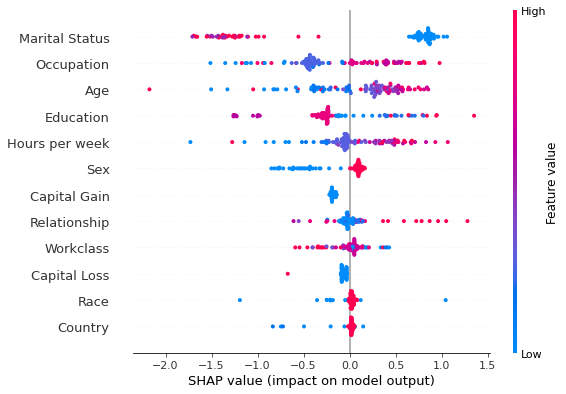

In [123]:
shap.summary_plot(shap_vals_misclassified, X_misclassified, feature_names )

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


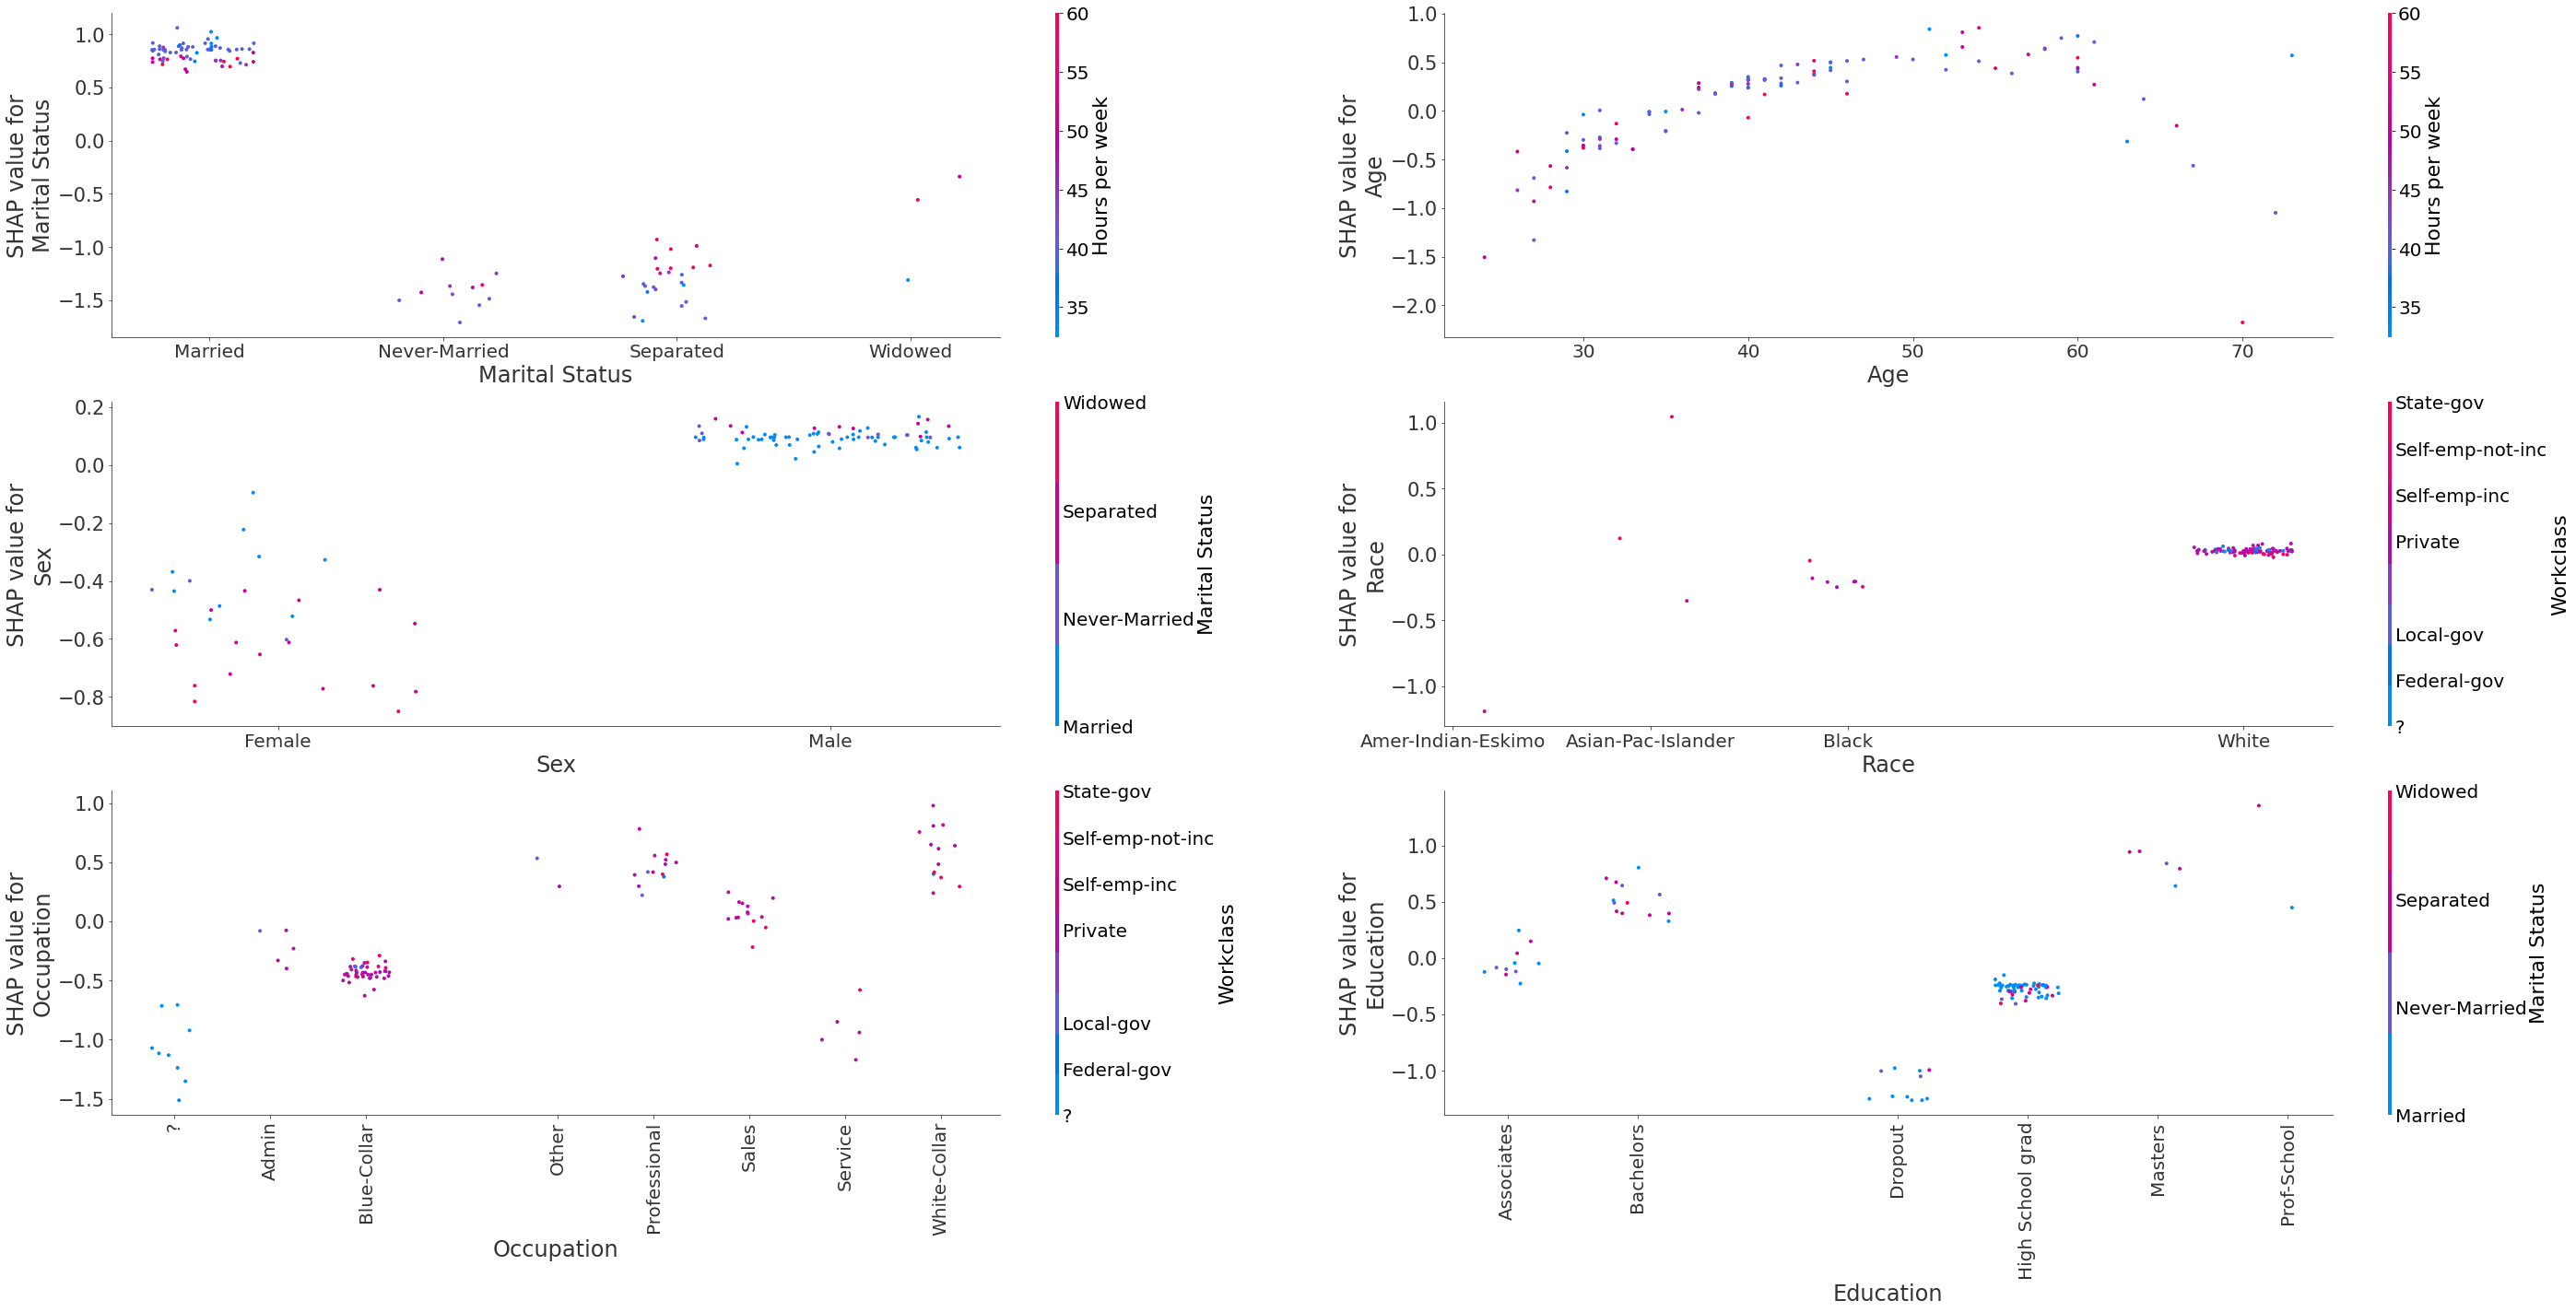

In [124]:
X_misclassified_display = decode_data(X_misclassified)
plot_dependence(
    ['Marital Status', 'Age',  'Sex', 'Race', 'Occupation', 'Education'],
    shap_vals_misclassified,
    X_misclassified,
    display_features=X_misclassified_display,
    rotation=33,
    figsize=(47.5, 22),
    alpha=1,
    x_jitter=0.5,
    nrows=3,
    ncols=2,
    xlabelfontsize=24,
    xtickfontsize=20,
    xticklabelrotation=0,
    ylabelfontsize=24,
    ytickfontsize=21,
    cbarlabelfontsize=22,
    cbartickfontsize=20,
    cbartickrotation=0,

)

### Model explanations with Shapley interaction values

In [125]:
shap_interactions_explanation = path_dependent_explainer.explain(X_test, interactions=True)
shap_interactions_values = shap_interactions_explanation.shap_interaction_values[0]

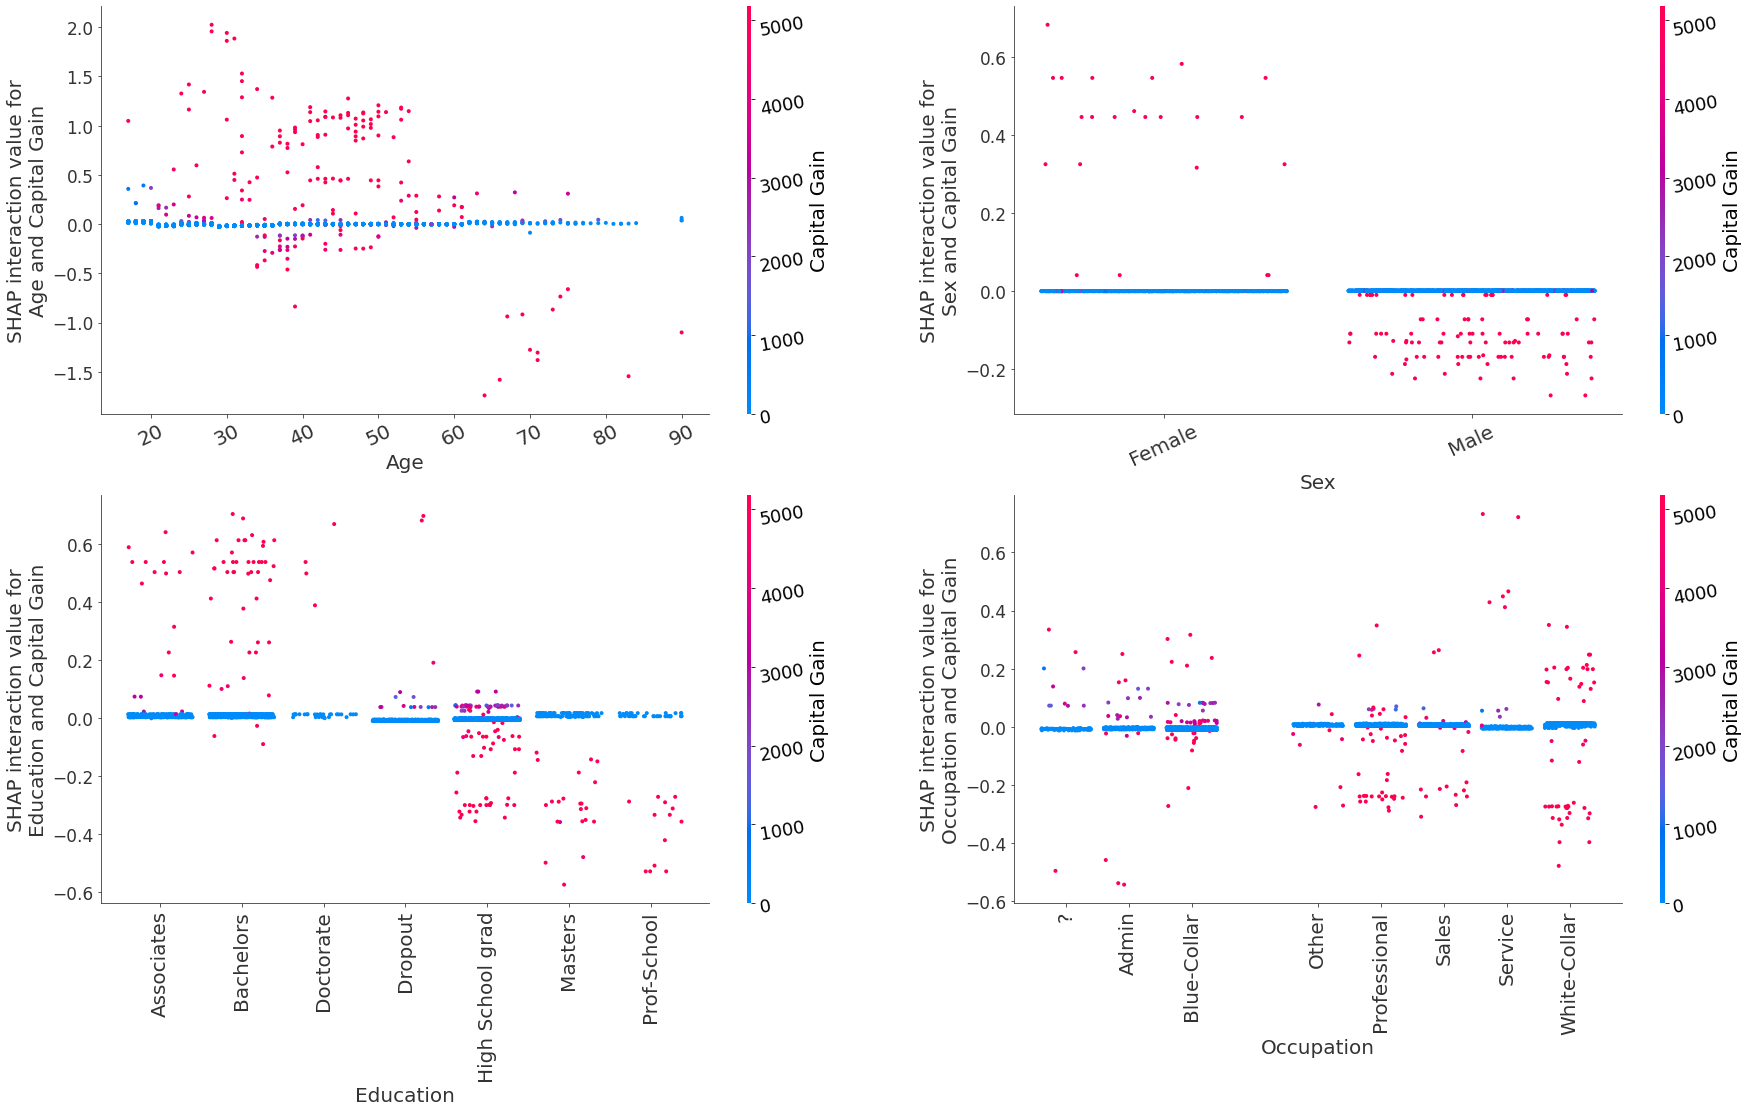

In [126]:
plot_dependence(
    [('Age', 'Capital Gain'),
    ('Sex', 'Capital Gain'),
    ('Education', 'Capital Gain'),
    ('Occupation', 'Capital Gain'),
    ],
    shap_interactions_values,
    X_test,
    figsize=(30,16.5),
    rotation=15,
    ncols=2,
    nrows=2,
    display_features=X_display,
    xtickfontsize=20,
    xlabelfontsize=20,
    ylabelfontsize=20,
    ytickfontsize=17,
    cbarlabelfontsize=20,
    cbartickfontsize=18,
)

In [127]:
def plot_decomposition(feature_pair, shap_interaction_vals, features, feat_names, display_features=None, **kwargs):
    """
    Given a list containing two feature names (`feature_pair`), an n_instances x n_features x n_features tensor
    of shap interaction values (`shap_interaction_vals`), an n_instances x n_features (`features`) tensor of
    feature values and a list of feature names (which assigns a name to each column of `features`), this function
    plots:
        - left: shap values for feature_pair[0] coloured by the value of feature_pair[1]
        - middle: shap values for feature_pair[0] after subtracting the interaction with feature_pair[1]
        - right: the interaction values between feature_pair[0] and feature_pair[1], which are subtracted
        from the left plot to get the middle plot

    NB: `display_features` is the same shape as `features` but should contain the raw categories for categorical
    variables so that the colorbar can be discretised and the category names displayed alongside the colorbar.
    """

    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    xlabelfontsize = kwargs.get('xlabelfontsize', 21)
    ylabelfontsize = kwargs.get('ylabelfontsize', 21)
    cbartickfontsize = kwargs.get('cbartickfontsize', 16)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 21)
    xtickfontsize = kwargs.get('xtickfontsize', 20)
    ytickfontsize = kwargs.get('ytickfontsize', 20)
    alpha = kwargs.get('alpha', 0.7)
    figsize = kwargs.get('figsize', (44, 10))
    ncols = kwargs.get('ncols', 3)
    nrows = kwargs.get('nrows', 1)
    # compute shap values and shap values without interaction
    feat1_idx = feat_names.index(feature_pair[0])
    feat2_idx = feat_names.index(feature_pair[1])
    # shap values
    shap_vals = shap_interaction_vals.sum(axis=2)
    # shap values for feat1, all samples
    shap_val_ind1 = shap_interaction_vals[..., feat1_idx].sum(axis=1)
    # shap values for (feat1, feat2) interaction
    shap_int_ind1_ind2 = shap_interaction_vals[:, feat2_idx, feat1_idx]
    # subtract effect of feat2
    shap_val_minus_ind2 = shap_val_ind1 - shap_int_ind1_ind2
    shap_val_minus_ind2 = shap_val_minus_ind2[:, None]

    # create plot

    fig, (ax1, ax2, ax3) = plt.subplots(nrows, ncols, figsize=figsize)

    # plot the shap values including the interaction
    shap.dependence_plot(feature_pair[0],
                         shap_vals,
                         features,
                         display_features = display_features,
                         feature_names=feat_names,
                         interaction_index=feature_pair[1],
                         alpha=alpha,
                         ax=ax1,
                         show=False)
    _set_fonts(fig, ax1, set_cbar=True)

    # plot the shap values excluding the interaction
    shap.dependence_plot(0,
                         shap_val_minus_ind2,
                         features[:, feat1_idx][:, None],
                         feature_names=[feature_pair[0]],
                         interaction_index=None,
                         alpha=alpha,
                         ax=ax2,
                         show=False,
                         )
    ax2.set_ylabel(f' Shap value for  {feature_pair[0]} \n wo {feature_pair[1]} interaction')
    _set_fonts(fig, ax2)

    # plot the interaction value
    shap.dependence_plot(feature_pair,
                         shap_interaction_vals,
                         features,
                         feature_names=feat_names,
                         display_features=display_features,
                         interaction_index='auto',
                         alpha=alpha,
                         ax=ax3,
                         show=False,
                        )
    _set_fonts(fig, ax3, set_cbar=True)

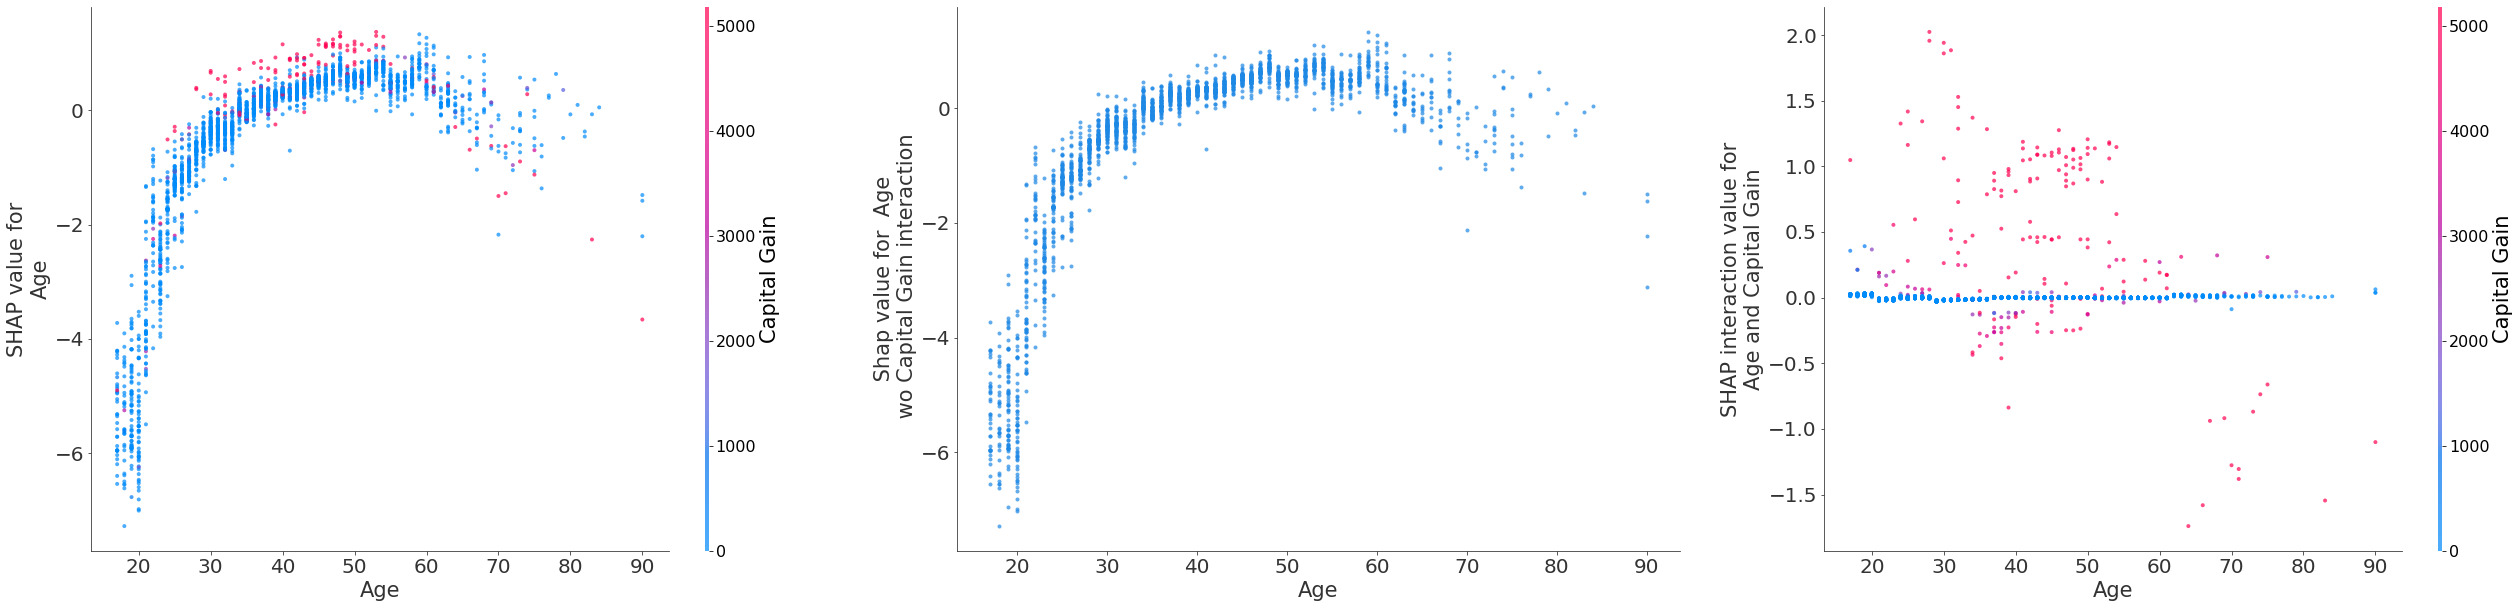

In [128]:
feature_pair = ('Age', 'Capital Gain')
plot_decomposition(
    feature_pair,
    shap_interactions_values,
    X_test,
    feature_names,
    display_features=X_display,
)